In [26]:
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import datetime
import os
import matplotlib.pyplot as plt
from keras.models import Sequential
import matplotlib.dates as mdates
from keras.layers import Dense,Dropout
from keras.optimizers import SGD
from sklearn.preprocessing import MinMaxScaler
from keras.layers import GRU

In [27]:
df_btc = pd.read_csv('BTC2019-2024.csv')
df_btc.info()
df_btc.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1815 entries, 0 to 1814
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  1815 non-null   int64  
 1   Date        1815 non-null   object 
 2   Open        1815 non-null   float64
 3   High        1815 non-null   float64
 4   Low         1815 non-null   float64
 5   Close       1815 non-null   float64
 6   Adj Close   1815 non-null   float64
 7   Volume      1815 non-null   int64  
dtypes: float64(5), int64(2), object(1)
memory usage: 113.6+ KB


,Unnamed: 0,Date,Open,High,Low,Close,Adj Close,Volume
1810,1810,2024-02-13,49941.359375,50358.390625,48406.496094,49742.441406,49742.441406,35593051468
1811,1811,2024-02-14,49733.445313,52021.371094,49296.832031,51826.695313,51826.695313,39105608050
1812,1812,2024-02-15,51836.785156,52820.066406,51371.628906,51938.554688,51938.554688,38564360533
1813,1813,2024-02-16,51937.726563,52537.968750,51641.367188,52160.203125,52160.203125,28180567298
1814,1814,2024-02-17,52161.675781,52180.582031,51558.039063,51724.253906,51724.253906,22865082368


In [28]:
target_data_btc = df_btc[['Close']]
target_data_btc.head()

,Close
0,3859.583740
1,3864.415039
2,3847.175781
3,3761.557129
4,3896.375000


In [29]:
scaler = MinMaxScaler(feature_range=(0, 1))
target_data_btc  = scaler.fit_transform(target_data_btc)

In [32]:
# Create training set

test_len  = int(0.3*len(target_data_btc))
train_len = int(0.7*len(target_data_btc))
timesteps = 545
features  = 1

X_train_btc = []
y_train_btc = []

for i in range(timesteps, train_len):
  X_train_btc.append(target_data_btc[i-timesteps:i, :])
  y_train_btc.append(target_data_btc[i, :])

X_train_btc = np.asarray(X_train_btc)
y_train_btc = np.asarray(y_train_btc)

# Reshaping
X_train_btc = np.reshape(X_train_btc, (X_train_btc.shape[0], X_train_btc.shape[1], 1))
print(X_train_btc.shape, y_train_btc.shape)

(725, 545, 1) (725, 1)


In [33]:
X_test_btc = []
y_test_btc = []

for i in range(train_len, target_data_btc.shape[0]):
  X_test_btc.append(target_data_btc[i-timesteps:i, :])
  y_test_btc.append(target_data_btc[i, :])

X_test_btc = np.asarray(X_test_btc)
y_test_btc = np.asarray(y_test_btc)

print(X_test_btc.shape, y_test_btc.shape)

(545, 545, 1) (545, 1)


In [34]:
# The GRU architecture
model_GRU = Sequential()
# First GRU layer with Dropout regularisation
model_GRU.add(GRU(50, return_sequences=True, input_shape=(X_train_btc.shape[1],1), activation='tanh'))
model_GRU.add(Dropout(0.2))
# Second GRU layer
model_GRU.add(GRU(50, return_sequences=True, activation='tanh'))
model_GRU.add(Dropout(0.2))
# Third GRU layer
model_GRU.add(GRU(50, return_sequences=True, activation='tanh'))
model_GRU.add(Dropout(0.2))
# Fourth GRU layer
model_GRU.add(GRU(50, activation='tanh'))
model_GRU.add(Dropout(0.2))
# The output layer
model_GRU.add(Dense(1))

In [35]:
optimizer=SGD(learning_rate=0.01, momentum=0.9)

In [36]:
# Compiling model
model_GRU.compile(optimizer= optimizer,loss='mean_squared_error')
# Fitting to the training set
model_GRU.fit(X_train_btc,y_train_btc,epochs=50,batch_size=150)

Epoch 1/50
5/5 [==============================] - 18s 2s/step - loss: 0.1785
Epoch 2/50
5/5 [==============================] - 11s 2s/step - loss: 0.1218
Epoch 3/50
5/5 [==============================] - 11s 2s/step - loss: 0.0593
Epoch 4/50
5/5 [==============================] - 11s 2s/step - loss: 0.0770
Epoch 5/50
5/5 [==============================] - 11s 2s/step - loss: 0.0461
Epoch 6/50
5/5 [==============================] - 10s 2s/step - loss: 0.0490
Epoch 7/50
5/5 [==============================] - 11s 2s/step - loss: 0.0370
Epoch 8/50
5/5 [==============================] - 11s 2s/step - loss: 0.0374
Epoch 9/50
5/5 [==============================] - 13s 3s/step - loss: 0.0284
Epoch 10/50
5/5 [==============================] - 11s 2s/step - loss: 0.0265
Epoch 11/50
5/5 [==============================] - 10s 2s/step - loss: 0.0207
Epoch 12/50
5/5 [==============================] - 11s 2s/step - loss: 0.0176
Epoch 13/50
5/5 [==============================] - 11s 2s/step - loss: 0.

In [37]:
y_pred_btc_GRU = model_GRU.predict(X_test_btc)
y_pred_btc_GRU = scaler.inverse_transform(y_pred_btc_GRU)
y_test_btc_GRU = scaler.inverse_transform(y_test_btc)

18/18 [==============================] - 7s 279ms/step


In [38]:
# Calculate RMSE
rmse = np.sqrt(np.mean(((y_pred_btc_GRU - y_test_btc_GRU) ** 2)))
print('Root Mean Squared Error:', rmse)

# Calculate MAPE
mape = np.mean(np.abs((y_test_btc_GRU - y_pred_btc_GRU) / y_test_btc_GRU))
print('Mean Absolute Percentage Error (MAPE):', mape)

## Calculate MSE
mse = np.mean((y_pred_btc_GRU - y_test_btc_GRU) ** 2)
print('Mean Squared Error:', mse)

Root Mean Squared Error: 1550.6629007793483
Mean Absolute Percentage Error (MAPE): 0.04309157168566185
Mean Squared Error: 2404555.431853423


In [17]:
# 13. Dự báo 90 ngày tiếp theo
from numpy import array

x_input = X_test_btc[60:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

lst_output = []
n_steps = 100
i = 0
while(i < 90):

    if(len(temp_input) > 100):
        # Lấy đúng 100 phần tử cuối cùng
        x_input = np.array(temp_input[-100:])
        print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape((1, n_steps, 1))
        # Dự đoán giá trị tiếp theo
        yhat = model_GRU.predict(x_input, verbose=0)
        print("{} day output {}".format(i, yhat))
        # Thêm giá trị dự đoán vào danh sách
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = np.array(temp_input).reshape((1, n_steps, 1))
        yhat = model_GRU.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

0 day input [0.51612613 0.52585642 0.52309932 0.52179016 0.51313626 0.49801659
 0.53473678 0.50768866 0.51461464 0.51444255 0.52699392 0.52841089
 0.50234495 0.52771162 0.52547483 0.53222443 0.53342358 0.5284448
 0.52491918 0.53396104 0.53439057 0.53210634 0.54740294 0.55974647
 0.56761507 0.5989872  0.63190847 0.62667061 0.61955864 0.63325559
 0.62634993 0.62719179 0.58744794 0.59068263 0.61325944 0.61534752
 0.59819824 0.6030624  0.5893417  0.60907165 0.60353901 0.62519432
 0.62859376 0.63061162 0.62656243 0.61522441 0.62458137 0.60745522
 0.62191254 0.6091393  0.60085702 0.6017582  0.60345532 0.63326704
 0.64565844 0.61259231 0.63346435 0.63319431 0.63047516 0.62975268
 0.67720027 0.66417982 0.67182882 0.6677666  0.61267056 0.61250152
 0.59610612 0.60732305 0.61740022 0.61093848 0.5877336  0.59331852
 0.59405796 0.59218035 0.56023287 0.56553311 0.56916171 0.56691635
 0.596429   0.6011807  0.59985697 0.6194894  0.61422907 0.60843011
 0.61615938 0.61788472 0.61485034 0.60844542 0.6096

In [20]:
df_btc1 = df_btc.reset_index()['Close']
scaler=MinMaxScaler(feature_range=(0,1))
df_btc1=scaler.fit_transform(np.array(df_btc1).reshape(-1,1))

In [21]:
train_data = df_btc1[:train_len]
test_data = df_btc1[train_len:train_len+test_len]


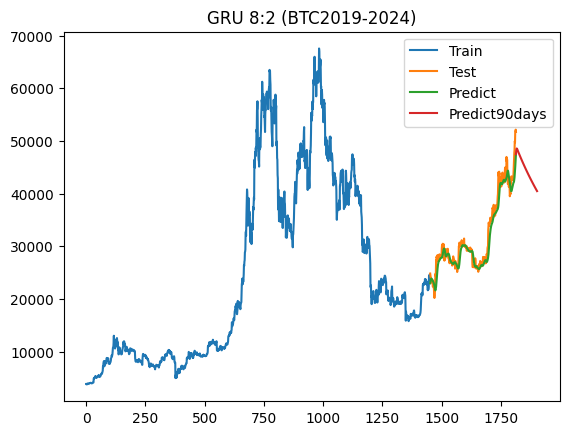

In [23]:
plt.title('GRU 8:2 (BTC2019-2024)')
train_data_index = pd.RangeIndex(start=0, stop=train_len, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_len, stop=train_len+test_len, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_len, stop=train_len+test_len, step=1)
plt.plot(test_data_index,(y_pred_btc_GRU))
prediect_data_index = pd.RangeIndex(start=len(df_btc)-1, stop=len(df_btc)+89, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Predict90days'])
plt.show()